In [8]:
%pylab inline

import gc
import fpfs
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel

Populating the interactive namespace from numpy and matplotlib


/lustre/work/xiangchong.li/ana/miniconda3/envs/cosmosis-mpich/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
ngrid=64
ngrid2=ngrid*1
psf=pyfits.getdata('../../sim/galaxy_basic_psf60/psf-60.fits')
if True:
    imgAll1=pyfits.getdata('../../sim/galaxy_basic_psf60/image-0-g1-0000.fits')
    imgAll2=pyfits.getdata('../../sim/galaxy_basic_psf60/image-0-g1-2222.fits')
else:
    pass
    
# PSF
npad          =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))

In [28]:
def test_knowref(img1,img2,psfF,do_plot=False):
    # prepare the Gaussian smoothing kernel
    gsigma=2.5*2.*np.pi/64
    gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
    k2grid,k1grid=grids
    imgF1=(np.fft.fft2(img1)/psfF)*gKer
    imgFQA1=imgF1*(k1grid**2.-k2grid**2.)/gsigma**2.
    imgFQB1=imgF1*(2.*k1grid*k2grid)/gsigma**2.
    imgFDA1=imgF1*(-1j*k1grid)
    imgFDB1=imgF1*(-1j*k2grid)

    imgF2=(np.fft.fft2(img2)/psfF)*gKer
    imgFQA2=imgF2*(k1grid**2.-k2grid**2.)/gsigma**2.
    imgFQB2=imgF2*(2.*k1grid*k2grid)/gsigma**2.
    imgFDA2=imgF2*(-1j*k1grid)
    imgFDB2=imgF2*(-1j*k2grid)

    imgCov1=np.fft.ifft2(imgF1).real
    imgCovQA1=np.fft.ifft2(imgFQA1).real
    imgCovQB1=np.fft.ifft2(imgFQB1).real
    imgCovDA1=np.fft.ifft2(imgFDA1).real
    imgCovDB1=np.fft.ifft2(imgFDB1).real

    imgCov2=np.fft.ifft2(imgF2).real
    imgCovQA2=np.fft.ifft2(imgFQA2).real
    imgCovQB2=np.fft.ifft2(imgFQB2).real
    imgCovDA2=np.fft.ifft2(imgFDA2).real
    imgCovDB2=np.fft.ifft2(imgFDB2).real
    if do_plot:
        dpad=20
        fig=plt.figure(figsize=(10,5))
        ax=fig.add_subplot(1,2,1)
        ax.imshow(img1[dpad:-dpad,dpad:-dpad],origin='lower',cmap='gray')
        ax.set_axis_off()
        ax=fig.add_subplot(1,2,2)
        ax.imshow(imgCov1[dpad:-dpad,dpad:-dpad],origin='lower',cmap='gray')
        ax.set_axis_off()
        plt.tight_layout()
        #fig.savefig('html/gal_psf_convolve.png')
    
    ygrid,xgrid = np.meshgrid(np.fft.fftfreq(64,1/64),np.fft.fftfreq(64,1/64),indexing='ij')
    xgrid=np.fft.fftshift(xgrid)
    ygrid=np.fft.fftshift(ygrid)
    resMap1=imgCovQA1+(xgrid+0.5)*imgCovDA1-(ygrid+0.5)*imgCovDB1
    resMap2=imgCovQA2+(xgrid+0.5)*imgCovDA2-(ygrid+0.5)*imgCovDB2
    resMap=(resMap1+resMap2)/2.
    resMapEst=(imgCov2-imgCov1)/0.04
    return resMap,resMapEst

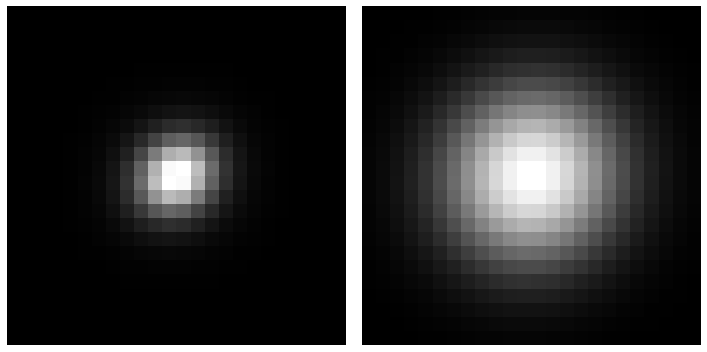

In [29]:
gc.collect()
img1=imgAll1[0:ngrid,0:ngrid]
img2=imgAll2[0:ngrid,0:ngrid]
resMap,resMapEst=test_knowref(img1,img2,psfF,do_plot=True)

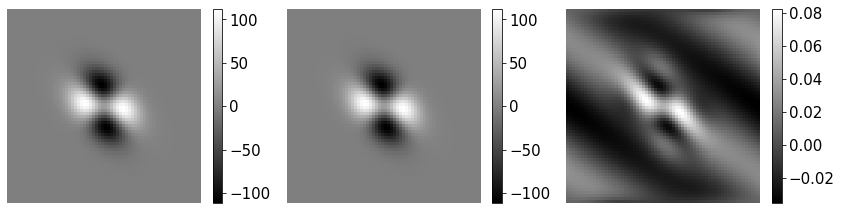

In [42]:
resAll=[]
resEstAll=[]
gc.collect()
for j in range(1,2):
    for i in range(0,1):
        img1=imgAll1[j*ngrid:(j+1)*ngrid,i*ngrid:(i+1)*ngrid]
        img2=imgAll2[j*ngrid:(j+1)*ngrid,i*ngrid:(i+1)*ngrid]
        resMap,resMapEst=test_knowref(img1,img2,psfF)
        resAll.append(resMap)
        resEstAll.append(resMapEst)
        del resMap,resMapEst,img1,img2
        gc.collect()
resMap=np.average(np.stack(resAll),axis=0)
resMapEst=np.average(np.stack(resEstAll),axis=0)

fig=plt.figure(figsize=(12,3))
ax1=fig.add_subplot(1,3,1)
im1=ax1.imshow(resMap*1e3,origin='lower',cmap='gray')
ax1.set_axis_off()
plt.colorbar(im1)
ax2=fig.add_subplot(1,3,2)
im2=ax2.imshow(resMapEst*1e3,origin='lower',cmap='gray')
ax2.set_axis_off()
plt.colorbar(im2)
ax3=fig.add_subplot(1,3,3)
im3=ax3.imshow(resMapEst*1e3-resMap*1e3,origin='lower',cmap='gray')
ax3.set_axis_off()
plt.colorbar(im3)
plt.tight_layout()
#fig.savefig('html/pixel_response_noiseless_centerknown.png')